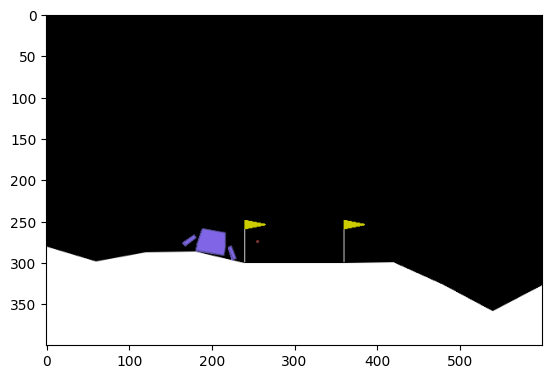

In [1]:
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('LunarLander-v3', continuous=True, gravity=-9.8, render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render())
for _ in range(100):
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [45]:
env.reset()

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.shape[0]

state_space_count, action_space_count

(8, 2)

In [53]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
observation, reward, terminated, truncated, info  = env.step(action)

observation, reward, terminated, truncated, info


(array([ 1.2280045e-01, -4.2328183e-02, -5.4894525e-01,  4.6053023e-10,
         6.0718343e-05,  3.6482561e-09,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 -100,
 True,
 False,
 {})

**observation**

The `observation` is an array of 8 values representing the state of the lander:

| Index | Value                   | Description                                      |
|-------|--------------------------|--------------------------------------------------|
| 0     | `x` position            | Horizontal position of the lander                |
| 1     | `y` position            | Vertical position of the lander                  |
| 2     | `x` velocity            | Horizontal velocity of the lander                |
| 3     | `y` velocity            | Vertical velocity of the lander                  |
| 4     | Angle                   | Orientation of the lander                        |
| 5     | Angular velocity        | Rotational speed of the lander                   |
| 6     | Left leg contact        | 1 if the left leg is touching the ground, else 0 |
| 7     | Right leg contact       | 1 if the right leg is touching the ground, else 0|

**reward**
- A numerical score for the action taken:
  - Positive reward for a smooth landing.
  - Negative reward for crashing or unstable behavior.
  - Extra points for leg contact with the landing pad.

**terminated**
- `True` if the episode ends because the lander has landed successfully or crashed.

**truncated**
- `True` if the episode ends because the maximum time limit is reached, not due to landing or crashing.

**info**
- A dictionary with additional details or metrics, primarily for debugging or analysis purposes.

In [5]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Abstract Agent Base Class
class Agent:
    def select_action(self, state):
        raise NotImplementedError

    def optimize_model(self):
        raise NotImplementedError

# Replay Memory for Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, observation, reward, done):
        self.memory.append((state, action, observation, reward, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Neural Network Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.model(x)

# Deep Double Q-Learning Agent
class DeepDoubleQAgent(Agent):
    def __init__(self, n_observations, n_actions, n_episodes, model, model2):
        self.n_actions = n_actions

        self.policy_net = model
        # self.target_net = type(model)(n_observations, n_actions)
        # self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net = model2

        self.update_target_network()
        self.target_net.eval()

        self.memory = ReplayMemory(50_000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.batch_size = 64
        self.gamma = 0.99
        self.eps_start = 0.99
        self.eps_end = 0.005
        self.eps_decay = n_episodes
        self.steps_done = 0

    def select_action(self, state, eval=False):
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if random.random() > eps_threshold or eval:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state).argmax(dim=1).item()
        else:
            return random.randrange(self.n_actions)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.tensor(np.array(batch[0]), dtype=torch.float32)
        action_batch = torch.tensor(np.array(batch[1]), dtype=torch.int64).unsqueeze(1)
        observation_batch = torch.tensor(np.array(batch[2]), dtype=torch.float32)
        reward_batch = torch.tensor(np.array(batch[3]), dtype=torch.float32).unsqueeze(1)
        done_batch = torch.tensor(np.array(batch[4]), dtype=torch.float32).unsqueeze(1)

        # Compute Q(s_t, a)
        q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) using Double Q-Learning
        with torch.no_grad():
            next_actions = self.policy_net(observation_batch).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(observation_batch).gather(1, next_actions)
            next_q_values = next_q_values * (1 - done_batch)

        expected_q_values = reward_batch + (self.gamma * next_q_values)

        # Compute loss
        loss = nn.MSELoss()(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Loop
def train_agent(env, agent, num_episodes, target_update=1, min_reward=-200):
    reward_history = []

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        terminated = truncated = False

        for t in range(1000):
            action = agent.select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action)
            ended = terminated | truncated
            total_reward += reward

            agent.memory.push(state, action, observation, reward, ended)
            agent.optimize_model()
            state = observation

            if ended or total_reward < min_reward:
                break

        if episode % target_update == 0:
            agent.update_target_network()

        reward_history.append(total_reward)

    env.close()
    return reward_history

env = gym.make('LunarLander-v3', continuous=False, gravity=-9.8, render_mode='rgb_array')

n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

n_episodes = 2000

model = DQN(n_observations, n_actions)
model2 = DQN(n_observations, n_actions)
agent = DeepDoubleQAgent(n_observations, n_actions, n_episodes, model, model2)

reward_history = train_agent(env, agent, n_episodes)
torch.save(agent.target_net.state_dict(), 'dqn_lunar_lander.pth')

  0%|          | 2/2000 [00:00<02:32, 13.11it/s]

100%|██████████| 2000/2000 [53:04<00:00,  1.59s/it] 


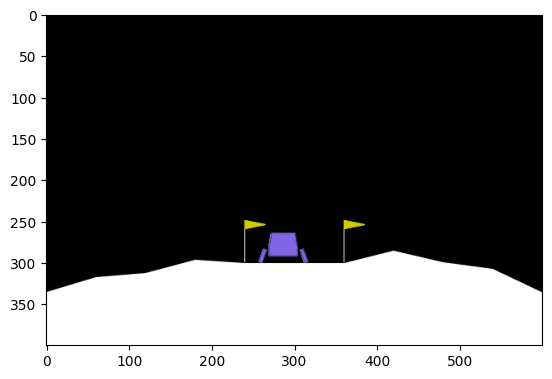

In [12]:
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('LunarLander-v3', continuous=False, gravity=-9.8, render_mode='rgb_array')
state, _ = env.reset()

img = plt.imshow(env.render())
terminated = truncated = False

while not terminated and not truncated:
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = agent.select_action(state, eval=True)
    observation, reward, terminated, truncated, info = env.step(action)
    state = observation

env.close()

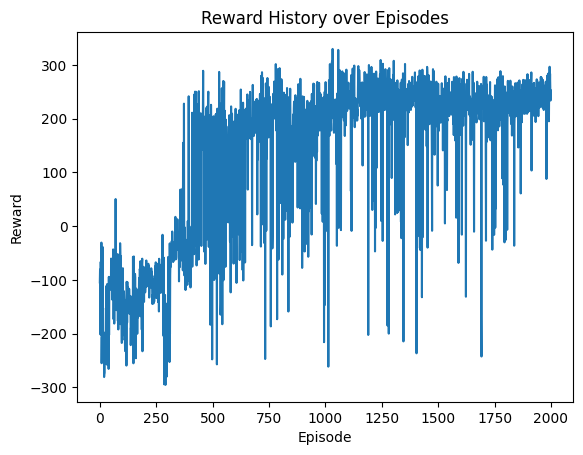

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(n_episodes), reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History over Episodes')
plt.show()

In [38]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Abstract Agent Base Class
class Agent:
    def select_action(self, state):
        raise NotImplementedError

    def optimize_model(self):
        raise NotImplementedError

# Replay Memory for Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, observation, reward, done):
        self.memory.append((state, action, observation, reward, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Neural Network Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.model(x)

# Deep Double Q-Learning Agent
class DeepDoubleQAgent(Agent):
    def __init__(self, n_observations, n_actions, n_episodes):
        self.n_actions = n_actions

        self.policy_net = DQN(n_observations, n_actions)
        self.target_net = DQN(n_observations, n_actions)
        self.update_target_network()
        self.target_net.eval()

        self.memory = ReplayMemory(250_000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.batch_size = 64
        self.gamma = 0.99
        self.eps_start = 0.99
        self.eps_end = 0.005
        self.eps_decay = n_episodes
        self.steps_done = 0

    def select_action(self, state):
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        batch_size = state.shape[0]

        if random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32)
                actions = self.policy_net(state_tensor).argmax(dim=1).cpu().numpy()
        else:
            actions = np.random.randint(0, self.n_actions, size=batch_size)
        return actions

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.tensor(np.array(batch[0]), dtype=torch.float32)
        action_batch = torch.tensor(np.array(batch[1]), dtype=torch.int64).unsqueeze(1)
        observation_batch = torch.tensor(np.array(batch[2]), dtype=torch.float32)
        reward_batch = torch.tensor(np.array(batch[3]), dtype=torch.float32).unsqueeze(1)
        done_batch = torch.tensor(np.array(batch[4]), dtype=torch.float32).unsqueeze(1)

        # Compute Q(s_t, a)
        q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) using Double Q-Learning
        with torch.no_grad():
            next_actions = self.policy_net(observation_batch).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(observation_batch).gather(1, next_actions)
            next_q_values = next_q_values * (1 - done_batch)

        expected_q_values = reward_batch + (self.gamma * next_q_values)

        # Compute loss
        loss = nn.MSELoss()(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Loop
# def train_agent(env, agent, num_episodes, target_update=1):
#     reward_history = []

#     num_envs = env.num_envs
#     episode_rewards = np.zeros(num_envs)
#     episode_lengths = np.zeros(num_envs)

#     total_steps = num_episodes // num_envs

#     state, _ = env.reset()
#     for curr_steps in tqdm(range(total_steps)):
#         action = agent.select_action(state)
#         next_state, reward, done, truncated, _ = env.step(action)

#         for i in range(num_envs):
#             agent.memory.push(state[i], action[i], next_state[i], reward[i], done[i])

#         agent.optimize_model()

#         state = next_state
#         episode_rewards += reward
#         episode_lengths += 1

#         for i in range(num_envs):
#             if done[i] or truncated[i]:
#                 reward_history.append(episode_rewards[i])
#                 episode_rewards[i] = 0
#                 episode_lengths[i] = 0

#         if curr_steps % (target_update * num_envs) == 0:
#             agent.update_target_network()

#         if curr_steps % 5 == 0 and curr_steps > 0:
#             print(f'Step: {curr_steps}, Reward: {np.mean(reward_history[-5:])}')

#     env.close()
#     return reward_history
def train_agent(env, agent, num_episodes, target_update=1):
    reward_history = []
    num_envs = env.num_envs
    episode_rewards = np.zeros(num_envs)
    episode_lengths = np.zeros(num_envs)
    episode_counts = np.zeros(num_envs)
    total_steps = 0

    state, _ = env.reset()
    while np.sum(episode_counts) < num_episodes:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        for i in range(num_envs):
            agent.memory.push(state[i], action[i], next_state[i], reward[i], done[i])

        agent.optimize_model()

        state = next_state
        episode_rewards += reward
        episode_lengths += 1

        for i in range(num_envs):
            if done[i] or truncated[i]:
                episode_counts[i] += 1
                reward_history.append(episode_rewards[i])
                episode_rewards[i] = 0
                episode_lengths[i] = 0

        if total_steps % (target_update * num_envs) == 0:
            agent.update_target_network()

        total_steps += 1

    env.close()
    return reward_history

num_envs = 32
env = gym.make_vec('LunarLander-v3', num_envs=num_envs, continuous=False, gravity=-9.8)

n_actions = env.action_space[0].n
n_observations = env.observation_space.shape[1]

n_episodes = 2000
agent = DeepDoubleQAgent(n_observations, n_actions, n_episodes)

reward_history = train_agent(env, agent, n_episodes)

In [39]:
len(reward_history)

2000

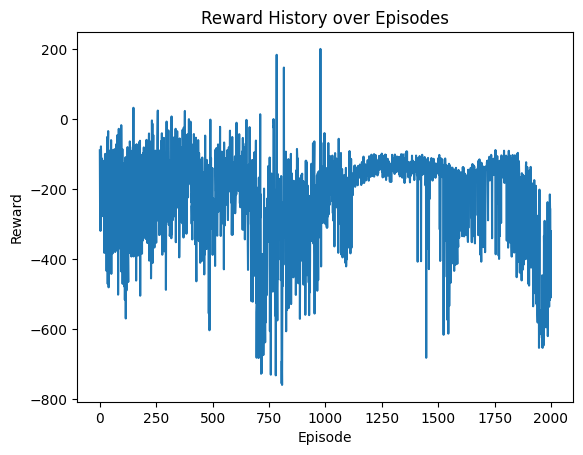

In [41]:
import matplotlib.pyplot as plt

plt.plot(range(n_episodes), reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History over Episodes')
plt.show()